In [374]:
from dateutil.parser import parse 
import pandas as pd
from datetime import datetime 
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
import matplotlib.pylab as plt
import statsmodels.api as sm
import math 
%matplotlib inline
import matplotlib.dates as mdate
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

After importing the required python libraries, I read the files into the data frames.

The complete data set is used for data exploration while the training and testing set are used mainly to build and evaluate model performances. Although the relationship between variables can be assessed in the complete dataset, the actual paper performs this task in the training set. In order to replicate the results as accurate as possible we are going to stick with that decision.
This portfolio task replicates an existing article about the use of appliances in a low-energy house (see references).

Finally the complete data is split in training and test validation. The 75% of the data is used for the training of the models and the rest is used for testing.



In [349]:
#READING THE THREE DATASETS
comp=pd.read_csv("data/energydata_complete.csv",index_col='date', parse_dates=True)
tr=pd.read_csv("data/training.csv",index_col='date', parse_dates=True)
tes=pd.read_csv("data/testing.csv",index_col='date', parse_dates=True)

print("The training dataset contains",tr.shape[0],'rows and ',tr.shape[1],'columns')
print("The testing dataset contains",tes.shape[0],'rows and ',tes.shape[1],'columns')

The training dataset contains 14803 rows and  31 columns
The testing dataset contains 4932 rows and  31 columns


# DATA EXPLORATION

The data analysis will be run in Python. The time span of the data set is 137 days (4.5 months).
The following graph shows the energy consumption profile for the entire period and for the first week (from 01/11/2016 17.00 to 01/18/2016 16.50).

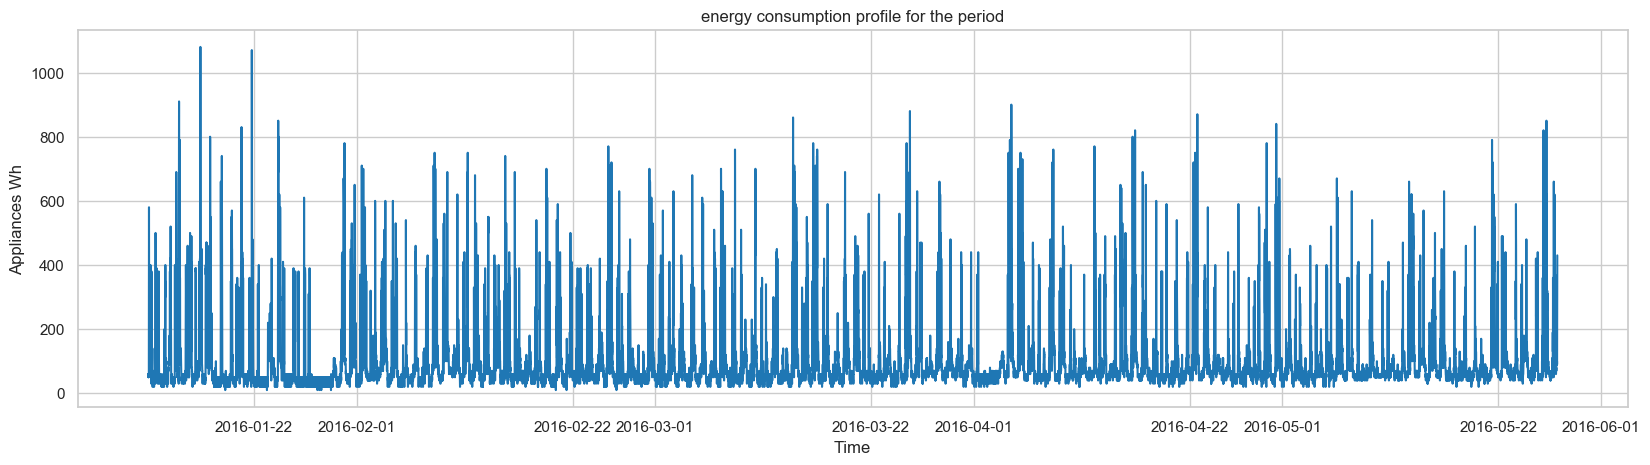

In [350]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    ''' create a time series according to the values passed to the parameters'''
    plt.figure(figsize=(20,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

#GENERATE A TIME SERIES FOR THE ALL PERIOD    
plot_df(comp, x=comp.index, y=comp.Appliances, title='energy consumption profile for the period',xlabel='Time',ylabel='Appliances Wh') 

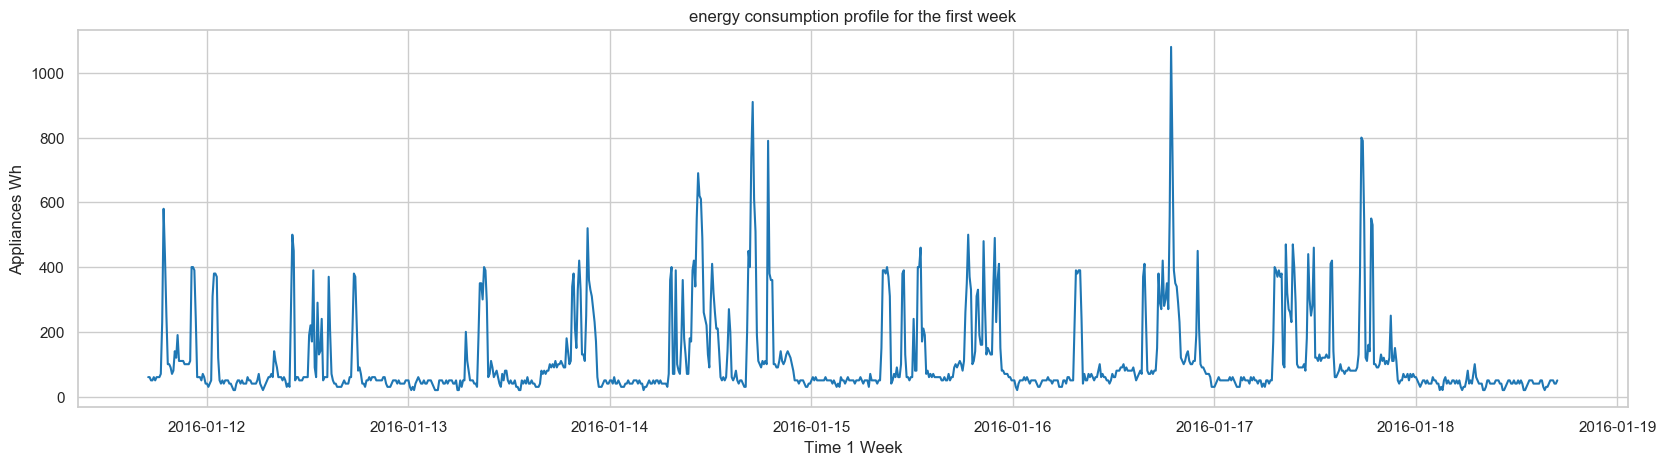

In [351]:
#SELECT ALL THE DATA FROM THE FIRST WEEK
comp_week=comp[:1008]

#GENERATE A TIME SERIES FOR THE ALL PERIOD
plot_df(comp_week, x=comp_week.index, y=comp_week.Appliances, title='energy consumption profile for the first week',xlabel='Time 1 Week',ylabel='Appliances Wh') 

The energy consumption profile shows a high variability with periods of almost constant demand followed by high spikes

The next graphs show an histogram and boxplot of the variable Appliances from the complete dataset. 

(0, 10000)

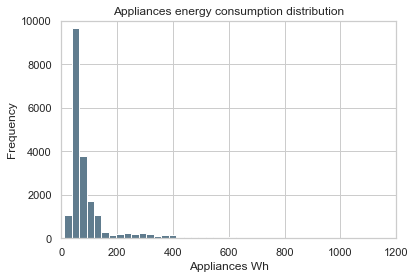

In [352]:
#HISTOGRAM
comp['Appliances'].plot.hist(color='#607c8e',rwidth=1,bins=40)
plt.title('Appliances energy consumption distribution')
plt.xlabel('Appliances Wh')
plt.ylabel('Frequency')
plt.xlim(0,1200)
plt.ylim(0,10000)


According to the graph, the data distribution has a long tail. The distribution is not symmetric and therefore skewed to the right. The majority of the values are within the range 0 to 180 Wh.

Text(0.5, 1.0, 'Appliances energy consumption boxplot')

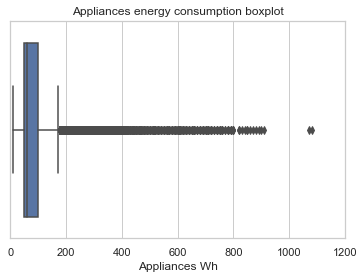

In [353]:
#BOXPLOT
sns.set(style="whitegrid")
ax = sns.boxplot("Appliances",data=comp,linewidth=1.5)
plt.xlabel('Appliances Wh')
plt.xlim(0,1200)
plt.title('Appliances energy consumption boxplot')


In the boxplot, the median is represented with a thick black line inside the blue rectangle, and has a value of 60 Wh.The lower whisker has a value of 10 Wh and the upper whisker has a value of 170 Wh. It also shows that the data above the median is more dispersed and that there are several outliers after the right whisker.

Next, the pair plots show the relationships between all the variables with the energy consumption of appliances in the training set. Three different pairplots are needed in order to split the variables and having a better visualization (in fact one pairplot with all the 31 variables would be difficult to interpret).

The pairplot shows the distribution of every variable in the diagonal (histogram) and the scatterplot with the regression line for every combination of variable.
In addition, a correlation matrix will be display in order to quantify these relations. Remember that a correlation of 1 is total positive correlation, −1 is total negative correlation and 0 represents no correlation.

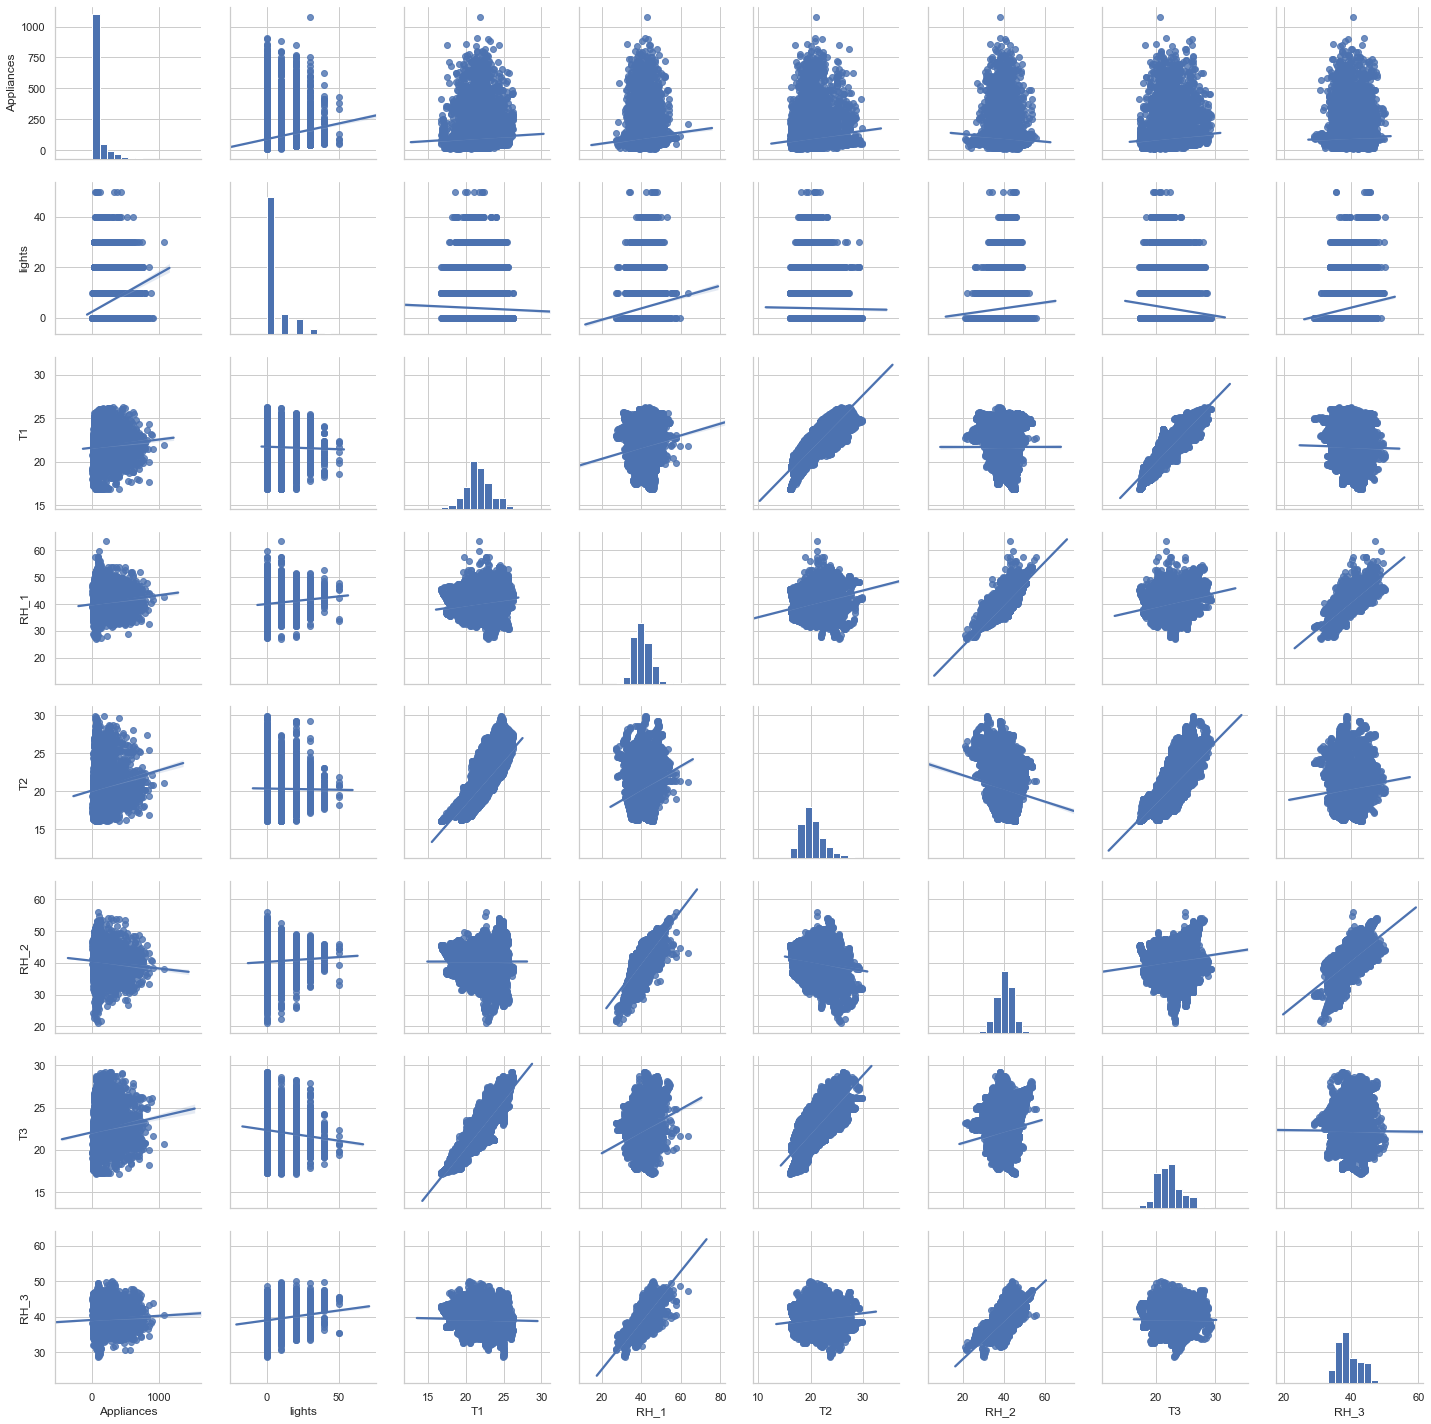

In [354]:
columns=['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3']
df=tr[columns]
sns.pairplot(df,kind='reg',diag_kind ='hist')


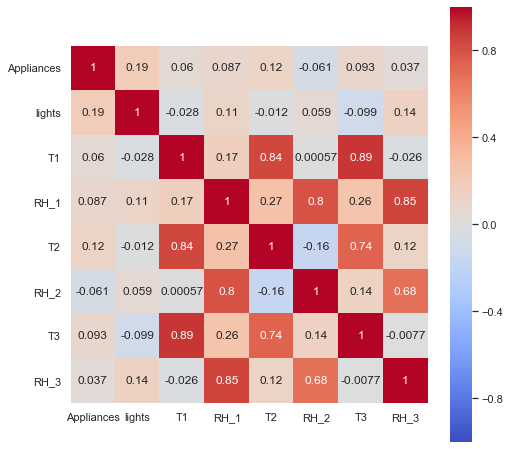

In [355]:
corrmat=df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corrmat,vmin=-1, vmax=1, square= True,annot=True,cmap='coolwarm')

The correlation matrix above shows that there is a positive correlation between the energy consumption of appliances and lights (0.19). The second largest correlation is between appliances and T2 (0.12). For the indoor temperatures, the correlations are high as expected, since the ventilation is driven by the HRV unit and minimizes air temperature differences between rooms. For example, a positive correlationis found with T1 and T3 (0.89)

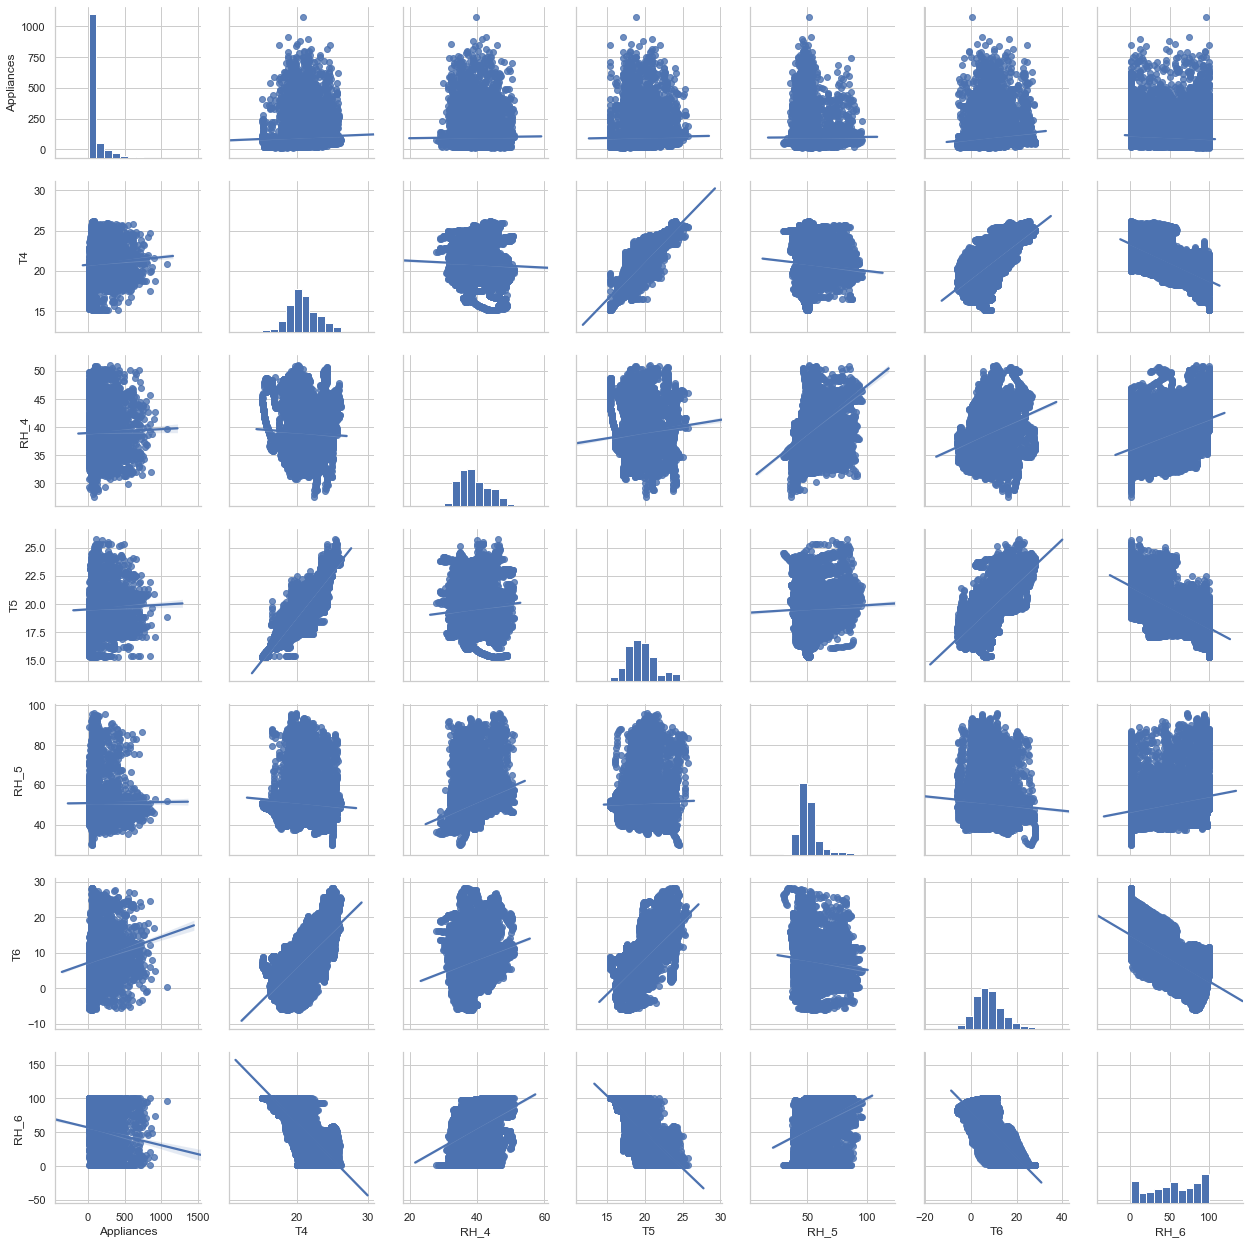

In [356]:
columns=['Appliances','T4', 'RH_4', 'T5', 'RH_5', 'T6','RH_6']
df_2=tr[columns]
sns.pairplot(df_2,kind='reg',diag_kind ='hist')

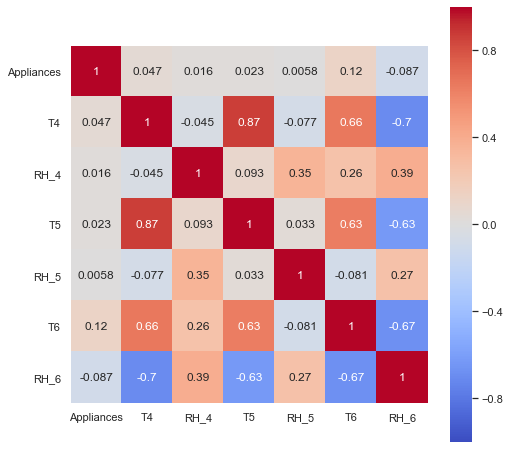

In [357]:
corrmat=df_2.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corrmat,vmin=-1, vmax=1, square= True,annot=True,cmap='coolwarm')

The correlation matrix above shows that the highest correlation with the appliances is between the outdoor temperature (0.12). Although it is almost 0, there is also a negative correlation between the appliances and outdoor humidity/RH6 (−.087).

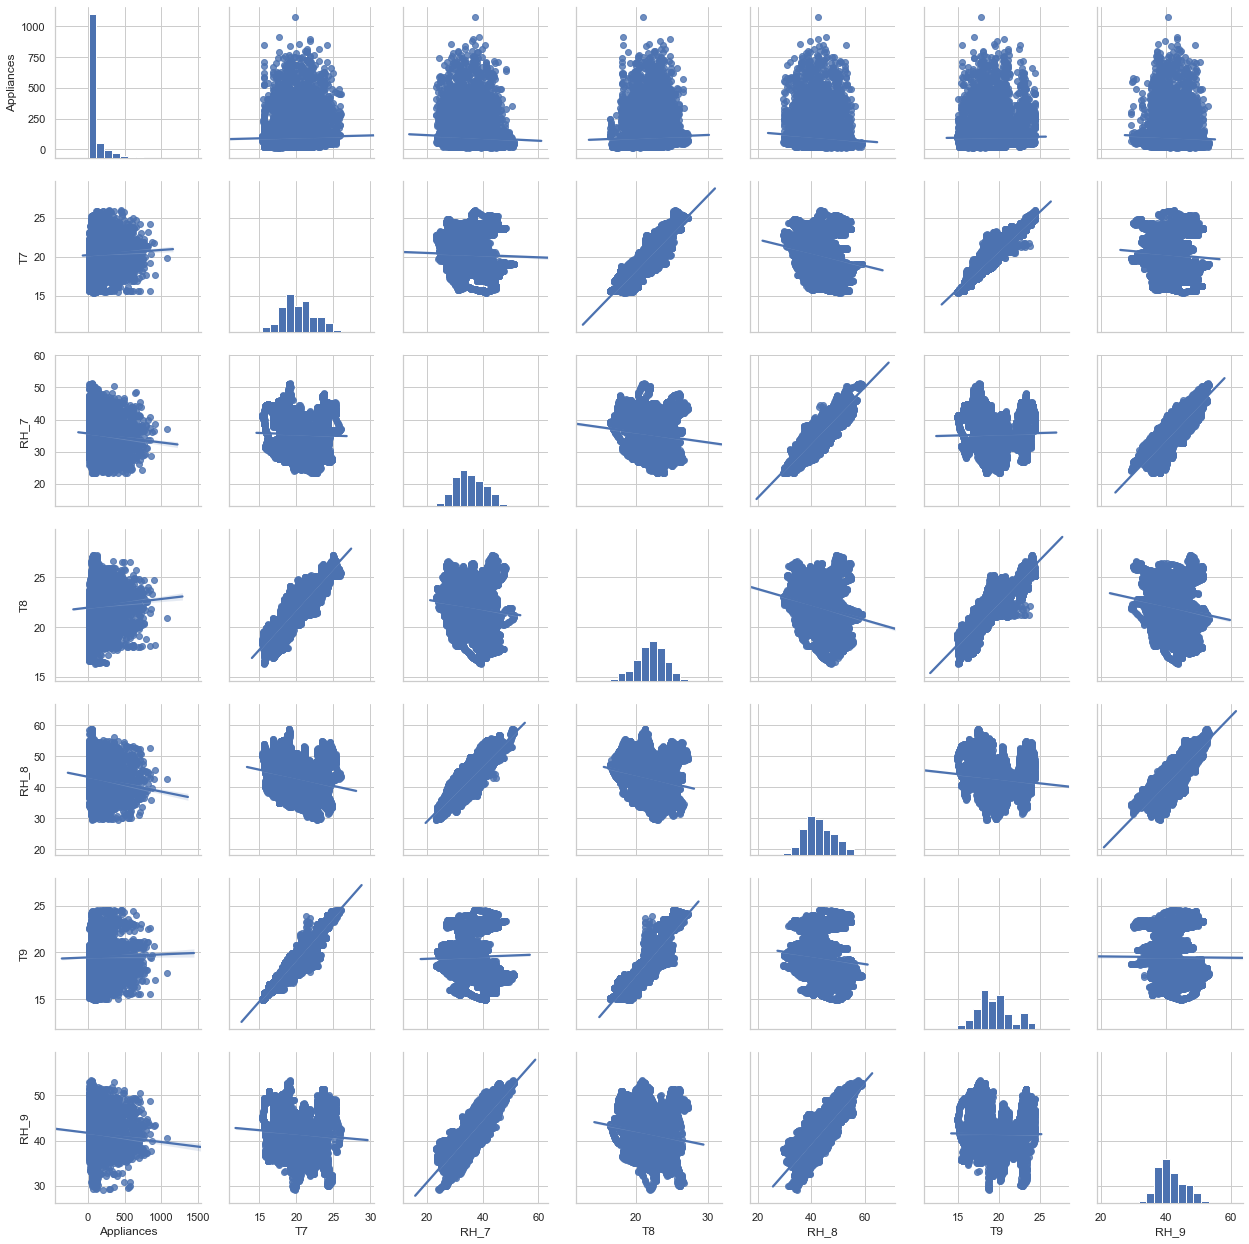

In [358]:
columns=['Appliances','T7', 'RH_7', 'T8', 'RH_8', 'T9','RH_9']
df_3=tr[columns]
sns.pairplot(df_3,kind='reg',diag_kind ='hist')

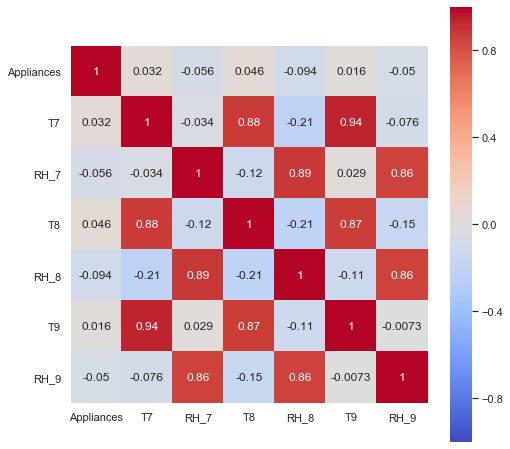

In [359]:
corrmat=df_3.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corrmat,vmin=-1, vmax=1, square= True,annot=True,cmap='coolwarm')

This correlation matrix actually shows that there is no linear relation between Appliances and the rest of these variables. In fact all the correlations are really close to zero.

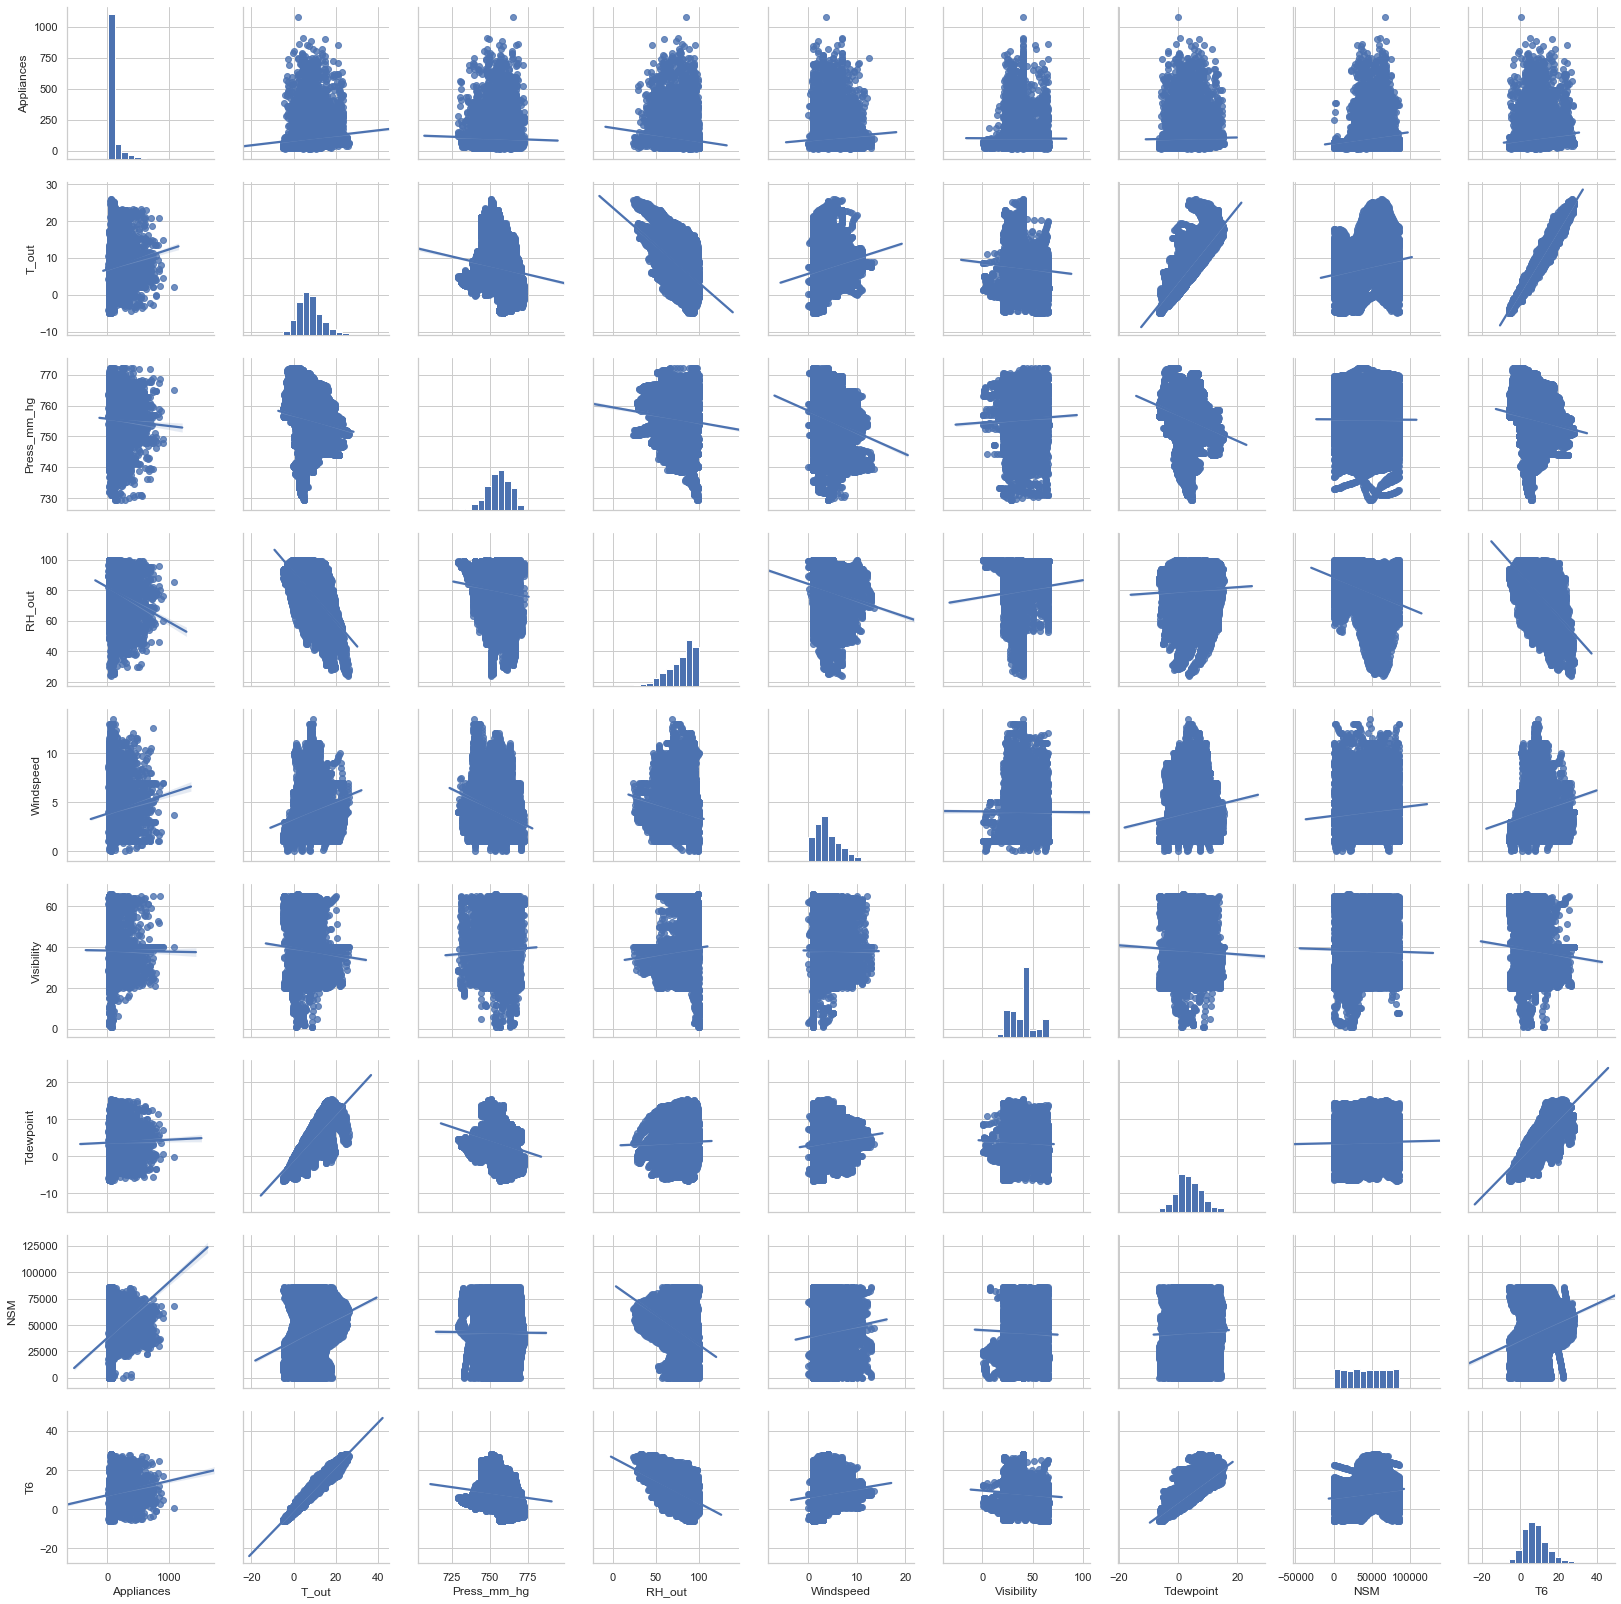

In [360]:
columns=['Appliances','T_out', 'Press_mm_hg', 'RH_out', 'Windspeed','Visibility','Tdewpoint', 'NSM','T6']
df_4=tr[columns]
sns.pairplot(df_4,kind='reg',diag_kind ='hist')

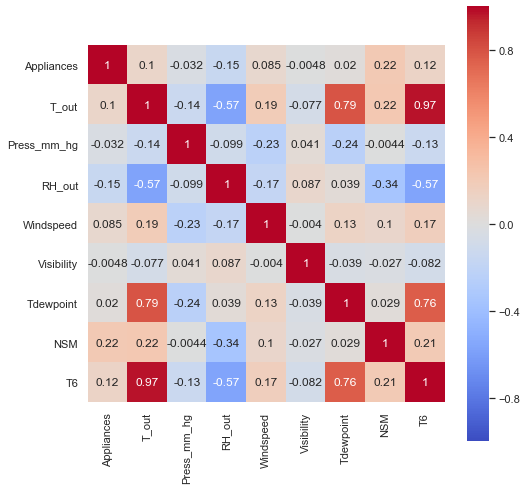

In [361]:
corrmat=df_4.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corrmat,vmin=-1, vmax=1, square= True,annot=True,cmap='coolwarm')

The last correlation matrix shows the highest correlation between the energy consumption of appliances and NSM with a value of 0.22. We might keep on eye on this variable since it might be a good predictor later on when we will build the regression line. A positive correlation of 0.10 is seen between appliances’ consumption and outdoor temperature (T_out) that is, the higher temperatures, the higher the energy use by the appliances. 
A negative linear relationship can be seen between Appliances and RH_out (-0.15). If the humidity outside decrease, the energy consumption of appliances increases.

Another important and interesting correlation is between the pressure and the wind speed. This relationship is negative (−0.24). The linear trend is with lowerpressure the wind speed will be higher.

# FEATURE SELECTION AND REGRESSION MODELS

Feature selection is one of the first thing we need to do before applying any model to the data. Since the dataset contains 31 columns, not necessarily every column is going to have an impact on the energy consumption. 
If we add these irrelevant features in the model, it will just make the model worst.
I am going to apply two different feauture selection methods: A filter method and a wrapper method.

Before doing this, categorical variables are converted into numeric variable too see whether they can be important predictors or not (this is done in a slightly different way in the paper). 

In [363]:
#CREATE TWO NUMERICAL VARIABLES FROM THE CATEGORICAL
def score_to_numeric(x):
    if x=='Weekday':
        return 0
    else:
        return 1
tr['WeekStatus_num'] = tr['WeekStatus'].apply(score_to_numeric)
tes['WeekStatus_num'] = tes['WeekStatus'].apply(score_to_numeric)


def score_to_numeric_2(x):
    if x=='Monday':
        return 1
    elif x=='Tuesday':
        return 2
    elif x=='Wednesday':
        return 3
    elif x=='Thursday':
        return 4
    elif x=='Friday':
        return 5
    elif x=='Saturday':
        return 6
    else:
        return 7
tr['Day_of_week_num'] = tr['Day_of_week'].apply(score_to_numeric_2)
tes['Day_of_week_num'] = tes['Day_of_week'].apply(score_to_numeric_2)


In [364]:
#DROP THE CATEGORICAL VARIABLE
columns = ['WeekStatus', 'Day_of_week']
tr.drop(columns, inplace=True, axis=1)
tes.drop(columns, inplace=True, axis=1)

### Filter method

The filter method selects a subset of the initial attributes according some criteria and only after a model is built on that subset. The filtering here is done using correlation matrix of the independent variables with the output variable.
Since the correlation obtained before were really small, our threeshold will be small too. We will only select features which has correlation of above 0.15 (taking absolute value) with the energy consumption.

In [365]:
cor = tr.corr()
#Correlation with output variable
cor_target = abs(cor['Appliances'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.15]
relevant_features

Appliances    1.000000
lights        0.194689
RH_out        0.154931
NSM           0.216167
Name: Appliances, dtype: float64

The highly correlated features with the output variable are 'lights','RH_out' and 'NSM'. Therefore we will drop all other variables apart from these. However, this is not the end of the process and another step is needed. 
One of the assumptions of linear regression is that the independent variables need to be uncorrelated with each other. Let's see if there is correlation between this hypothetical predictors.

In [366]:
print(tr[["lights","RH_out"]].corr())
print(tr[["RH_out","NSM"]].corr())
print(tr[["lights","NSM"]].corr())

          lights    RH_out
lights  1.000000  0.070385
RH_out  0.070385  1.000000
          RH_out       NSM
RH_out  1.000000 -0.344305
NSM    -0.344305  1.000000
          lights       NSM
lights  1.000000  0.250096
NSM     0.250096  1.000000


The predictors are not highly correlated to each other which means we can keep all of them.
In conclusion the filter method select three variables as important and they are 'lights','RH_out' and 'NSM'. A linear regression model is built to the training dataset and it will be evaluate into the testing. 

In [370]:
#BUILDING A REGRESSION MODEL WITH FEATURES FROM THE FILTER METHOD
reg = linear_model.LinearRegression()
X_train= tr[['lights', 'RH_out','NSM']]
y_train= tr['Appliances']
reg.fit(X_train, y_train)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [ 2.20543955e+00 -8.35837616e-01  5.42453962e-04] + 132.95165116547474


In [375]:
#PERFORMANCE ON TRAINING
predicted = reg.predict(X_train)
print("RMSE:", math.sqrt(mean_squared_error(y_train, predicted)))
print("R^2:", r2_score(y_train, predicted))

RMSE: 98.60097860218349
R^2: 0.08046376165320868


In [376]:
#TESTING
X_test = tes[['lights', 'RH_out','NSM']]
y_test = tes['Appliances']
#PERFORMANCE ON TESTING
predicted = reg.predict(X_test)
print("RMSE:", math.sqrt(mean_squared_error(y_test, predicted)))
print("R^2:", r2_score(y_test, predicted))

RMSE: 97.41512023459899
R^2: 0.08075159793794395


Conclusion: Although the model do not have overfitting problem (The r2 has similar values between training data and testing data), it performs really poorly. The model is only able to explain 8% of the total variance in the energy consumption of appliances.

### Wrapper method


A wrapper method differs from the filter method because it needs a machine learning algorithm and its performance as evaluation criteria. This means, you feed the predictors to regression model and based on the performance you may include or remove a certain feature. This is usually consider more efficient method than the filter method.

The wrapped method used here is the RFE (Recursive Feature Elimination). RFE works by recursively deleting features and building a model on those features that remain. It also return a boolean list according to the importance of the variable: True means relevant feature and False means irrelevant feature.

In order to find the optimal number of features that will make sure highest accuracy, we need to use a loop that iterate over all features.

In [377]:
#TRAINING AND TESTING SET
X_train=tr.drop('Appliances',axis=1)
X_test=tes.drop('Appliances',axis=1)
y_train= tr['Appliances']
y_test= tes['Appliances']

In [388]:
#no of features
nof_list=np.arange(1,X_train.shape[1])            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[] #here we get all the accuracy score for each iteration from 1 to N
for n in range(len(nof_list)):
    
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    predicted = model.predict(X_test_rfe)
    RMSE=math.sqrt(mean_squared_error(y_test, predicted))
    score=r2_score(y_test, predicted)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        rmse=RMSE
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("R^2 with %d features: %f" % (nof, high_score))
print("RMSE with %d features: %f" % (nof, rmse))

Optimum number of features: 24
R^2 with 24 features: 0.149783
RMSE with 24 features: 93.686049


The optimal number of features is 24 (24/30). A linear regression with the most important 24 predictors produces almost 15% accuracy. It has been proven that wrapper method is better than filter method.
Those results are actually really similar to those shown in the research paper (R^2 = 0.16, RSME = 93.18)

In [ ]:
#residual graph for the last linear regression THAT COMMENT WHAT THE PAPER COMMENT
#heatmap TRY

# REFERENCES

Data driven prediction models of energy use of appliances in a low-energy house. Luis M. Candanedo, Véronique Feldheim, Dominique Deramaix. Energy and Buildings, Volume 140, 1 April 2017, Pages 81-97, ISSN 0378-7788, http://dx.doi.org/10.1016/j.enbuild.2017.01.083.

Feature Selection with sklearn and Pandas,Introduction to Feature Selection methods and their implementation in Python.Abhini Shetye
https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b